In [1]:
import pandas as pd
from datetime import timedelta

In [2]:
matches = pd.read_csv("../../preprocessing/data/matches.csv")
matches = matches.sort_values(by='Date')

In [3]:
player_history = {}

def calculate_fatigue_score(player_id, current_date, player_history):
    if player_id not in player_history:
        player_history[player_id] = []
    

    last_7_days = [match for match in player_history[player_id] if current_date - match['Date'] <= timedelta(days=7)]
    
    last_7_days_weighted_sum = sum(
        0.85 ** ((current_date - match['Date']).days -1) * (match['minutes'])
        for match in last_7_days
    )
    return last_7_days_weighted_sum

# Calculate fatigue scores for each match row
for i, row in matches.iterrows():
    current_date = pd.to_datetime(row['Date'])
    winner_id = row['winner_id']
    loser_id = row['loser_id']
    minutes = row['minutes']
    
    winner_fatigue = calculate_fatigue_score(winner_id, current_date, player_history)
    loser_fatigue = calculate_fatigue_score(loser_id, current_date, player_history)
    matches.at[i, 'winner_fatigue_score'] = winner_fatigue
    matches.at[i, 'loser_fatigue_score'] = loser_fatigue
    
    # Update player history with current match
    player_history[winner_id].append({'Date': current_date, 'minutes': minutes})
    player_history[loser_id].append({'Date': current_date, 'minutes': minutes})

matches[['Date', 'winner_id', 'loser_id', 'minutes', 'winner_fatigue_score', 'loser_fatigue_score', 'winner_rank', 'loser_rank']]

,Date,winner_id,loser_id,minutes,winner_fatigue_score,loser_fatigue_score,winner_rank,loser_rank
0,2017-12-31,105238,106043,93.0,0.000000,0.000000,38.0,26.0
1,2017-12-31,200282,105449,104.0,0.000000,0.000000,208.0,44.0
30,2018-01-01,105932,105341,76.0,0.000000,0.000000,59.0,73.0
29,2018-01-01,106233,105539,96.0,0.000000,0.000000,5.0,72.0
28,2018-01-01,104269,104534,110.0,0.000000,0.000000,35.0,67.0
...,...,...,...,...,...,...,...,...
14081,2023-11-10,207686,105732,77.0,210.900625,286.936706,63.0,344.0
14108,2023-11-10,207733,105526,84.0,215.207500,200.450000,82.0,28.0
14109,2023-11-10,105173,200303,85.0,246.400000,271.757500,25.0,80.0
14083,2023-11-11,200005,207686,67.0,238.360000,256.265531,23.0,63.0


In [4]:
rank_differences = [5, 10, 25, 50, float('inf')]

results = {}

non_zero_rows = matches[
    (matches['winner_fatigue_score'] != 0) | (matches['loser_fatigue_score'] != 0)
]
for rank_diff in rank_differences:
    valid_rows = non_zero_rows[
        (non_zero_rows['winner_rank'].astype(float) - non_zero_rows['loser_rank'].astype(float)).abs() < rank_diff
    ]

    count_less = (valid_rows['winner_fatigue_score'] < valid_rows['loser_fatigue_score']).sum()
    count_greater = (valid_rows['winner_fatigue_score'] > valid_rows['loser_fatigue_score']).sum()
    count_equal = (valid_rows['winner_fatigue_score'] == valid_rows['loser_fatigue_score']).sum()

    total_filtered_rows = len(valid_rows)
    if total_filtered_rows > 0:
        percentage_less = (count_less / total_filtered_rows) * 100
        percentage_greater = (count_greater / total_filtered_rows) * 100
        percentage_equal = (count_equal / total_filtered_rows) * 100
    else:
        percentage_less = percentage_greater = percentage_equal = 0

    results[rank_diff] = {
        'total_filtered_rows': total_filtered_rows,
        'percentage_less': percentage_less,
        'percentage_greater': percentage_greater,
        'percentage_equal': percentage_equal
    }

for rank_diff, metrics in results.items():
    print(f"Rank Difference < {rank_diff}:")
    print(f"  Percentage where winner < loser: {metrics['percentage_less']}%")
    print(f"  Percentage where winner > loser: {metrics['percentage_greater']}%")
    print(f"  Percentage where winner == loser: {metrics['percentage_equal']}%")
    print(f"  Total filtered rows: {metrics['total_filtered_rows']}\n")

Rank Difference < 5:
  Percentage where winner < loser: 52.46153846153846%
  Percentage where winner > loser: 47.53846153846154%
  Percentage where winner == loser: 0.0%
  Total filtered rows: 650

Rank Difference < 10:
  Percentage where winner < loser: 51.45833333333333%
  Percentage where winner > loser: 48.333333333333336%
  Percentage where winner == loser: 0.20833333333333334%
  Total filtered rows: 1440

Rank Difference < 25:
  Percentage where winner < loser: 50.90077977951062%
  Percentage where winner > loser: 48.8303307340683%
  Percentage where winner == loser: 0.26888948642108096%
  Total filtered rows: 3719

Rank Difference < 50:
  Percentage where winner < loser: 51.21621621621622%
  Percentage where winner > loser: 48.43843843843844%
  Percentage where winner == loser: 0.34534534534534533%
  Total filtered rows: 6660

Rank Difference < inf:
  Percentage where winner < loser: 51.61378805888269%
  Percentage where winner > loser: 48.02048093627137%
  Percentage where winn

C:\Users\Pawel\AppData\Local\Temp\ipykernel_508\3410085391.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


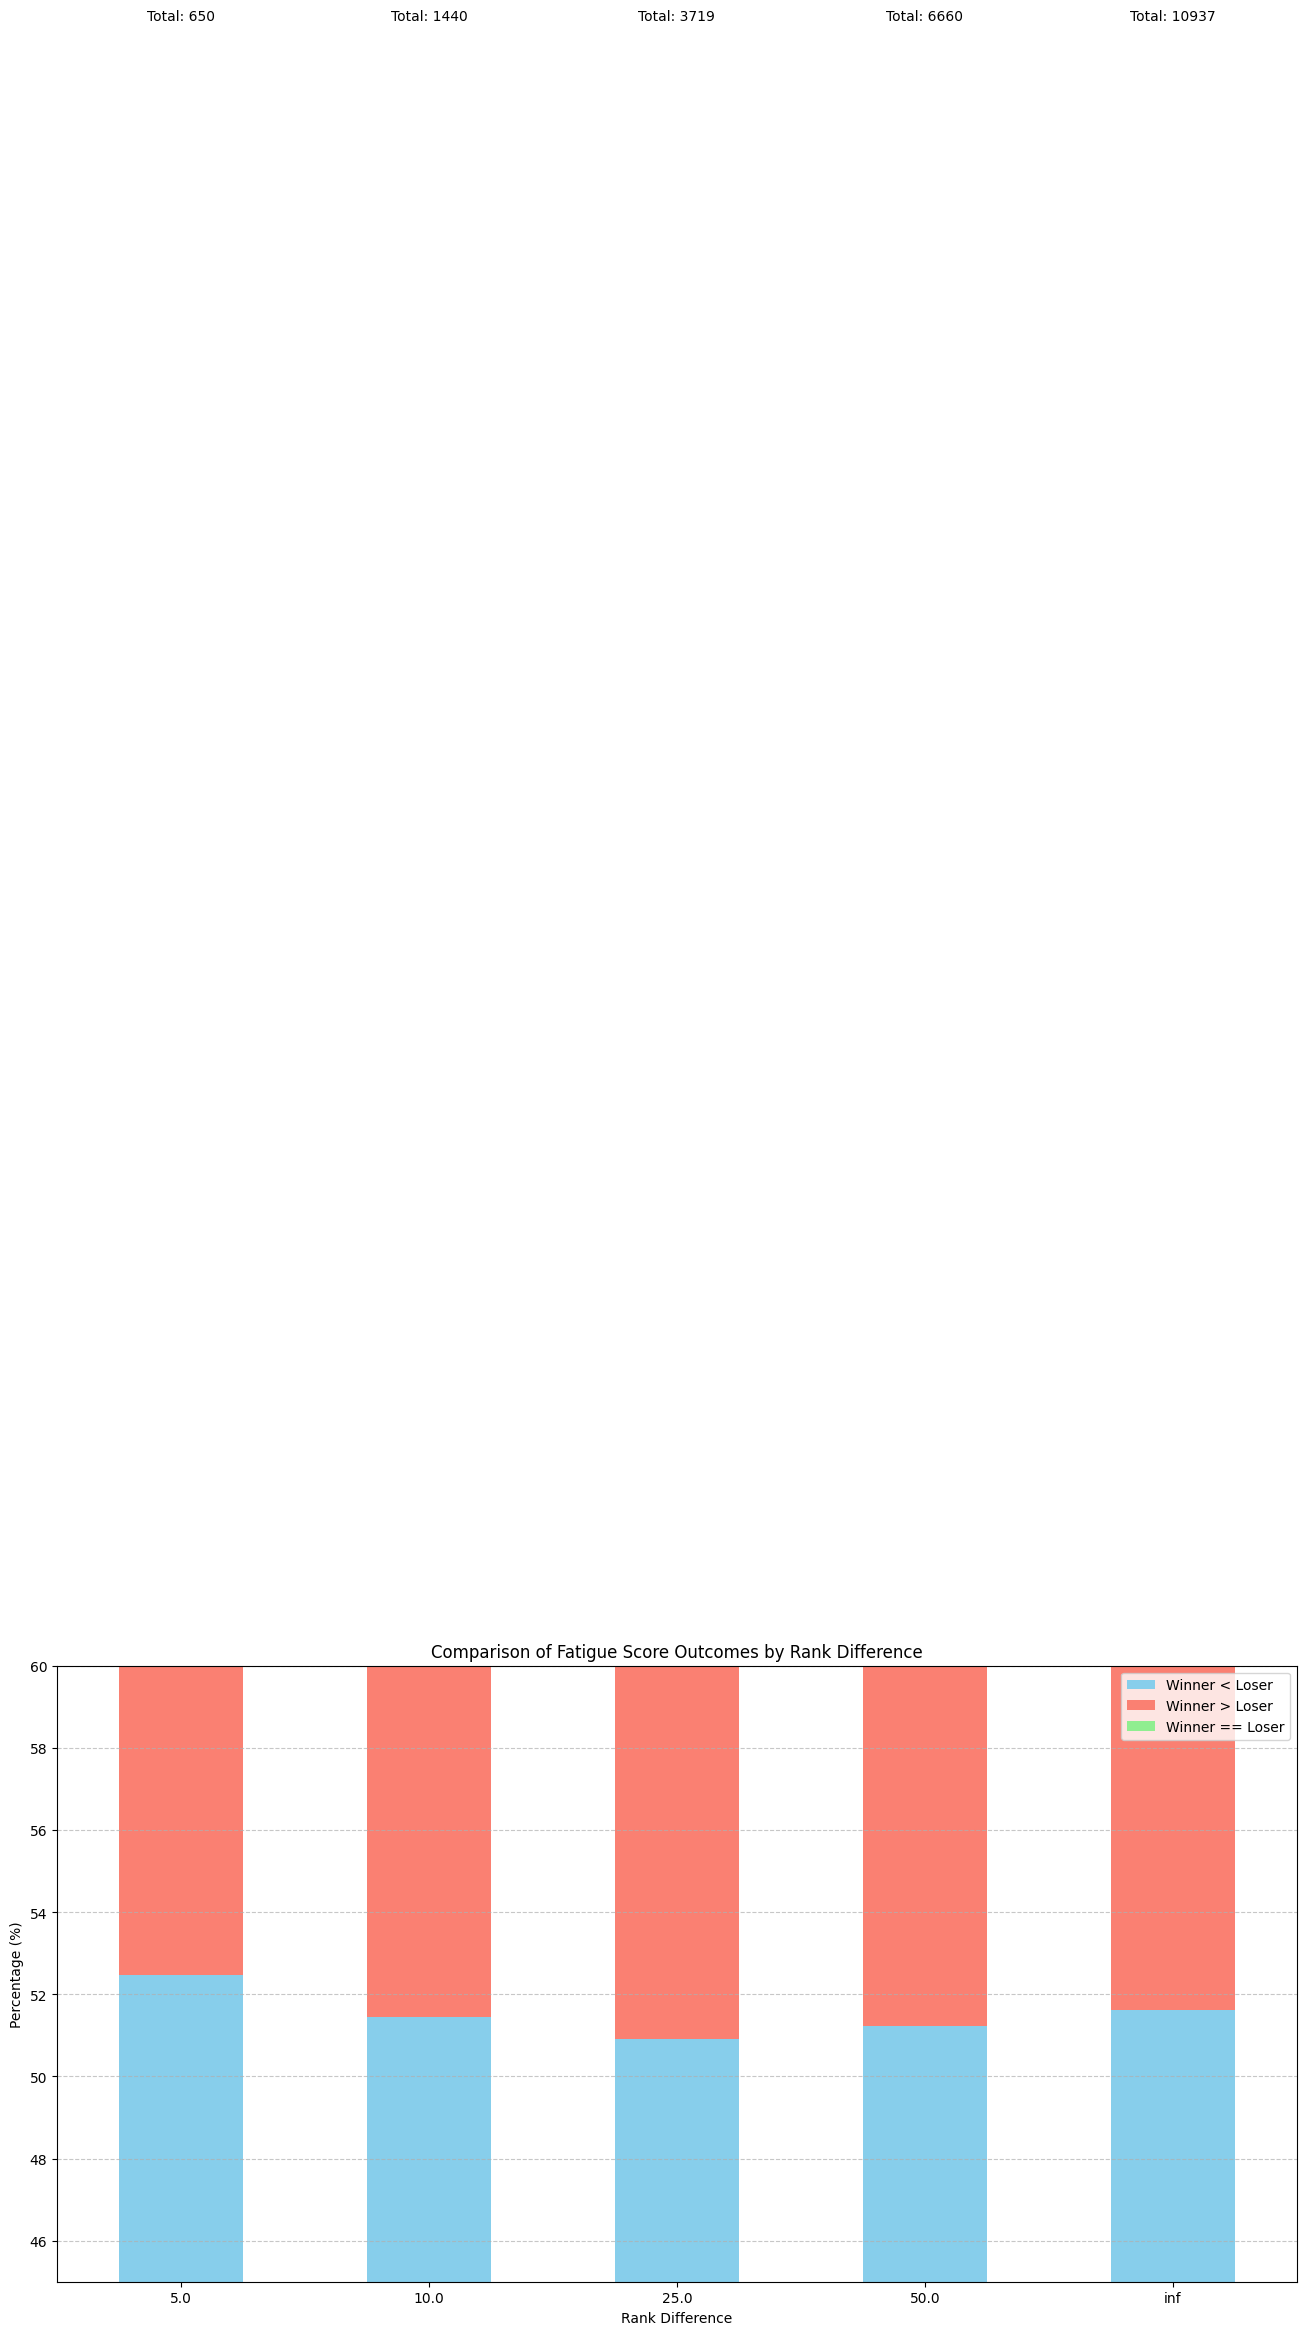

In [5]:
import matplotlib.pyplot as plt


df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'Rank Difference'

plt.figure(figsize=(16, 8))
df[['percentage_less', 'percentage_greater', 'percentage_equal']].plot(
    kind='bar', stacked=True, ax=plt.gca(), color=['skyblue', 'salmon', 'lightgreen']
)

plt.ylim(45, 60)

plt.title('Comparison of Fatigue Score Outcomes by Rank Difference')
plt.xlabel('Rank Difference')
plt.ylabel('Percentage (%)')
plt.legend(['Winner < Loser', 'Winner > Loser', 'Winner == Loser'])
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, total in enumerate(df['total_filtered_rows']):
    plt.text(i, 100, f'Total: {total}', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [6]:
matches[["match_id", 'winner_fatigue_score', 'loser_fatigue_score']].to_csv("../data/fatigue.csv", index=False)